# Hyperparameters

This example simulates the alignment of a KB mirror endstation (with four degrees of freedom).

In [1]:
%run -i prepare_re_env.py --db-type=temp
bec.disable_plots()

In [2]:
from blop.sim import Beamline

beamline = Beamline(name="bl")

In [3]:
from blop import DOF, Objective, Agent
from blop.digestion import beam_stats_digestion

dofs = [
    DOF(description="KBV downstream", device=beamline.kbv_dsv, search_domain=(-5.0, 5.0)),
    DOF(description="KBV upstream", device=beamline.kbv_usv, search_domain=(-5.0, 5.0)),
    DOF(description="KBH downstream", device=beamline.kbh_dsh, search_domain=(-5.0, 5.0)),
    DOF(description="KBH upstream", device=beamline.kbh_ush, search_domain=(-5.0, 5.0)),
]

objectives = [
    Objective(name="bl_det_sum", target="max", transform="log", trust_domain=(200, np.inf)),
    Objective(name="bl_det_wid_x", target="min", transform="log", latent_groups=[("bl_kbh_dsh", "bl_kbh_ush")]),
    Objective(name="bl_det_wid_y", target="min", transform="log", latent_groups=[("bl_kbv_dsv", "bl_kbv_usv")]),
]

agent = Agent(
    dofs=dofs,
    objectives=objectives,
    detectors=[beamline.det],
    digestion=beam_stats_digestion,
    digestion_kwargs={"image_key": "bl_det_image"},
    verbose=True,
    db=db,
    tolerate_acquisition_errors=False,
    enforce_all_objectives_valid=True,
    train_every=3,
)

(uid,) = RE(agent.learn("qr", n=32))

2025-02-18 10:24:41.907 INFO: Executing plan <generator object Agent.learn at 0x7f0f585d70b0>
2025-02-18 10:24:41.908 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f0f59030fe0> from 'idle' -> 'running'
2025-02-18 10:24:41.908 INFO: running iteration 1 / 1




Transient Scan ID: 1     Time: 2025-02-18 10:24:41
Persistent Unique Scan ID: 'f08f5c87-f538-4bdb-ac08-8a770ccb2497'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 10:24:41.9 |      0.902 |     -0.339 |     -0.121 |      0.413 |    540.881 |      209.571 |      130.457 |       24.966 |       29.909 |
|         2 | 10:24:41.9 |     -0.784 |     -2.468 |     -1.949 |     -0.312 |    392.059 |      231.798 |      128.236 |       84.563 |       94.083 |
|         3 | 10:24:42.0 |      0.455 |     -2.999 |     -4.254 |     -4.967 |     22.591 |      20

2025-02-18 10:24:44.163 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f0f59030fe0> from 'running' -> 'idle'
2025-02-18 10:24:44.164 INFO: Cleaned up from plan <generator object Agent.learn at 0x7f0f585d70b0>


In [4]:
RE(agent.learn("qei", n=4, iterations=4))

2025-02-18 10:24:44.168 INFO: Executing plan <generator object Agent.learn at 0x7f0f585d7a10>
2025-02-18 10:24:44.169 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f0f59030fe0> from 'idle' -> 'running'
2025-02-18 10:24:44.170 INFO: running iteration 1 / 4




Transient Scan ID: 2     Time: 2025-02-18 10:24:45
Persistent Unique Scan ID: '6c5a853e-2254-43e6-86f6-19938f20122f'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 10:24:45.6 |      0.546 |     -0.734 |     -0.900 |     -0.417 |    524.312 |      208.426 |      129.907 |       62.649 |       44.356 |
|         2 | 10:24:45.7 |     -0.926 |      2.109 |      1.566 |     -0.348 |    546.276 |      160.933 |      194.458 |       17.345 |       18.246 |
|         3 | 10:24:45.7 |     -1.016 |      1.958 |      0.293 |      0.124 |    545.373 |      19

2025-02-18 10:24:46.692 INFO: running iteration 2 / 4




Transient Scan ID: 3     Time: 2025-02-18 10:24:47
Persistent Unique Scan ID: '99673ed5-8db1-4695-9f17-aae4719e059a'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 10:24:47.7 |     -1.465 |      2.823 |      0.399 |      0.715 |    533.841 |      205.319 |      213.062 |       16.769 |       15.481 |
|         2 | 10:24:47.8 |      1.064 |     -1.234 |      0.466 |      0.088 |    552.701 |      191.488 |      114.553 |       20.076 |       43.853 |
|         3 | 10:24:47.8 |      1.753 |     -1.018 |      1.106 |      0.319 |    543.398 |      18

2025-02-18 10:24:48.337 INFO: running iteration 3 / 4




Transient Scan ID: 4     Time: 2025-02-18 10:24:49
Persistent Unique Scan ID: '4c38a61b-7d42-43f2-977d-650cfe196868'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 10:24:49.8 |     -2.074 |      2.490 |      1.532 |     -0.606 |    366.785 |      156.448 |      211.377 |       16.537 |       22.362 |
|         2 | 10:24:49.8 |     -0.658 |      3.568 |      3.933 |     -2.217 |      0.081 |      171.260 |      156.469 |      317.252 |      263.896 |
|         3 | 10:24:49.9 |      0.309 |      2.859 |      2.429 |     -0.571 |    538.790 |      13

2025-02-18 10:24:50.523 INFO: running iteration 4 / 4




Transient Scan ID: 5     Time: 2025-02-18 10:24:51
Persistent Unique Scan ID: '065b57ba-3f3c-4694-b3b6-ba9a882ab00d'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|   seq_num |       time | bl_kbv_dsv | bl_kbv_usv | bl_kbh_dsh | bl_kbh_ush | bl_det_sum | bl_det_cen_x | bl_det_cen_y | bl_det_wid_x | bl_det_wid_y |
+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+--------------+--------------+
|         1 | 10:24:51.9 |     -0.478 |      1.723 |     -2.110 |      2.074 |    499.754 |      281.244 |      181.967 |       29.701 |       17.447 |
|         2 | 10:24:51.9 |      0.987 |      3.102 |     -0.453 |      1.043 |    543.559 |      228.671 |      180.620 |       19.826 |       42.123 |
|         3 | 10:24:51.9 |      1.390 |      2.435 |      0.198 |      1.371 |    536.188 |      22

2025-02-18 10:24:52.941 INFO: Change state on <bluesky.run_engine.RunEngine object at 0x7f0f59030fe0> from 'running' -> 'idle'
2025-02-18 10:24:52.942 INFO: Cleaned up from plan <generator object Agent.learn at 0x7f0f585d7a10>


('6c5a853e-2254-43e6-86f6-19938f20122f',
 '99673ed5-8db1-4695-9f17-aae4719e059a',
 '4c38a61b-7d42-43f2-977d-650cfe196868',
 '065b57ba-3f3c-4694-b3b6-ba9a882ab00d')

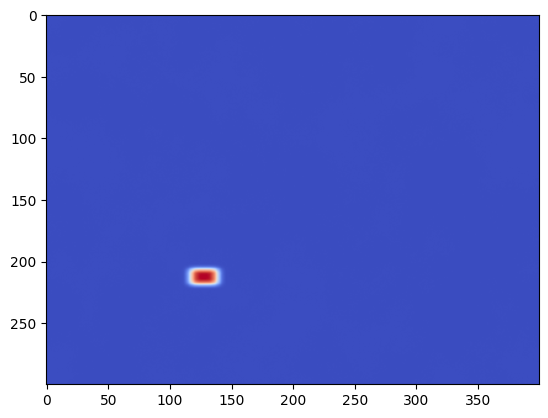

In [5]:
plt.imshow(agent.best.bl_det_image)

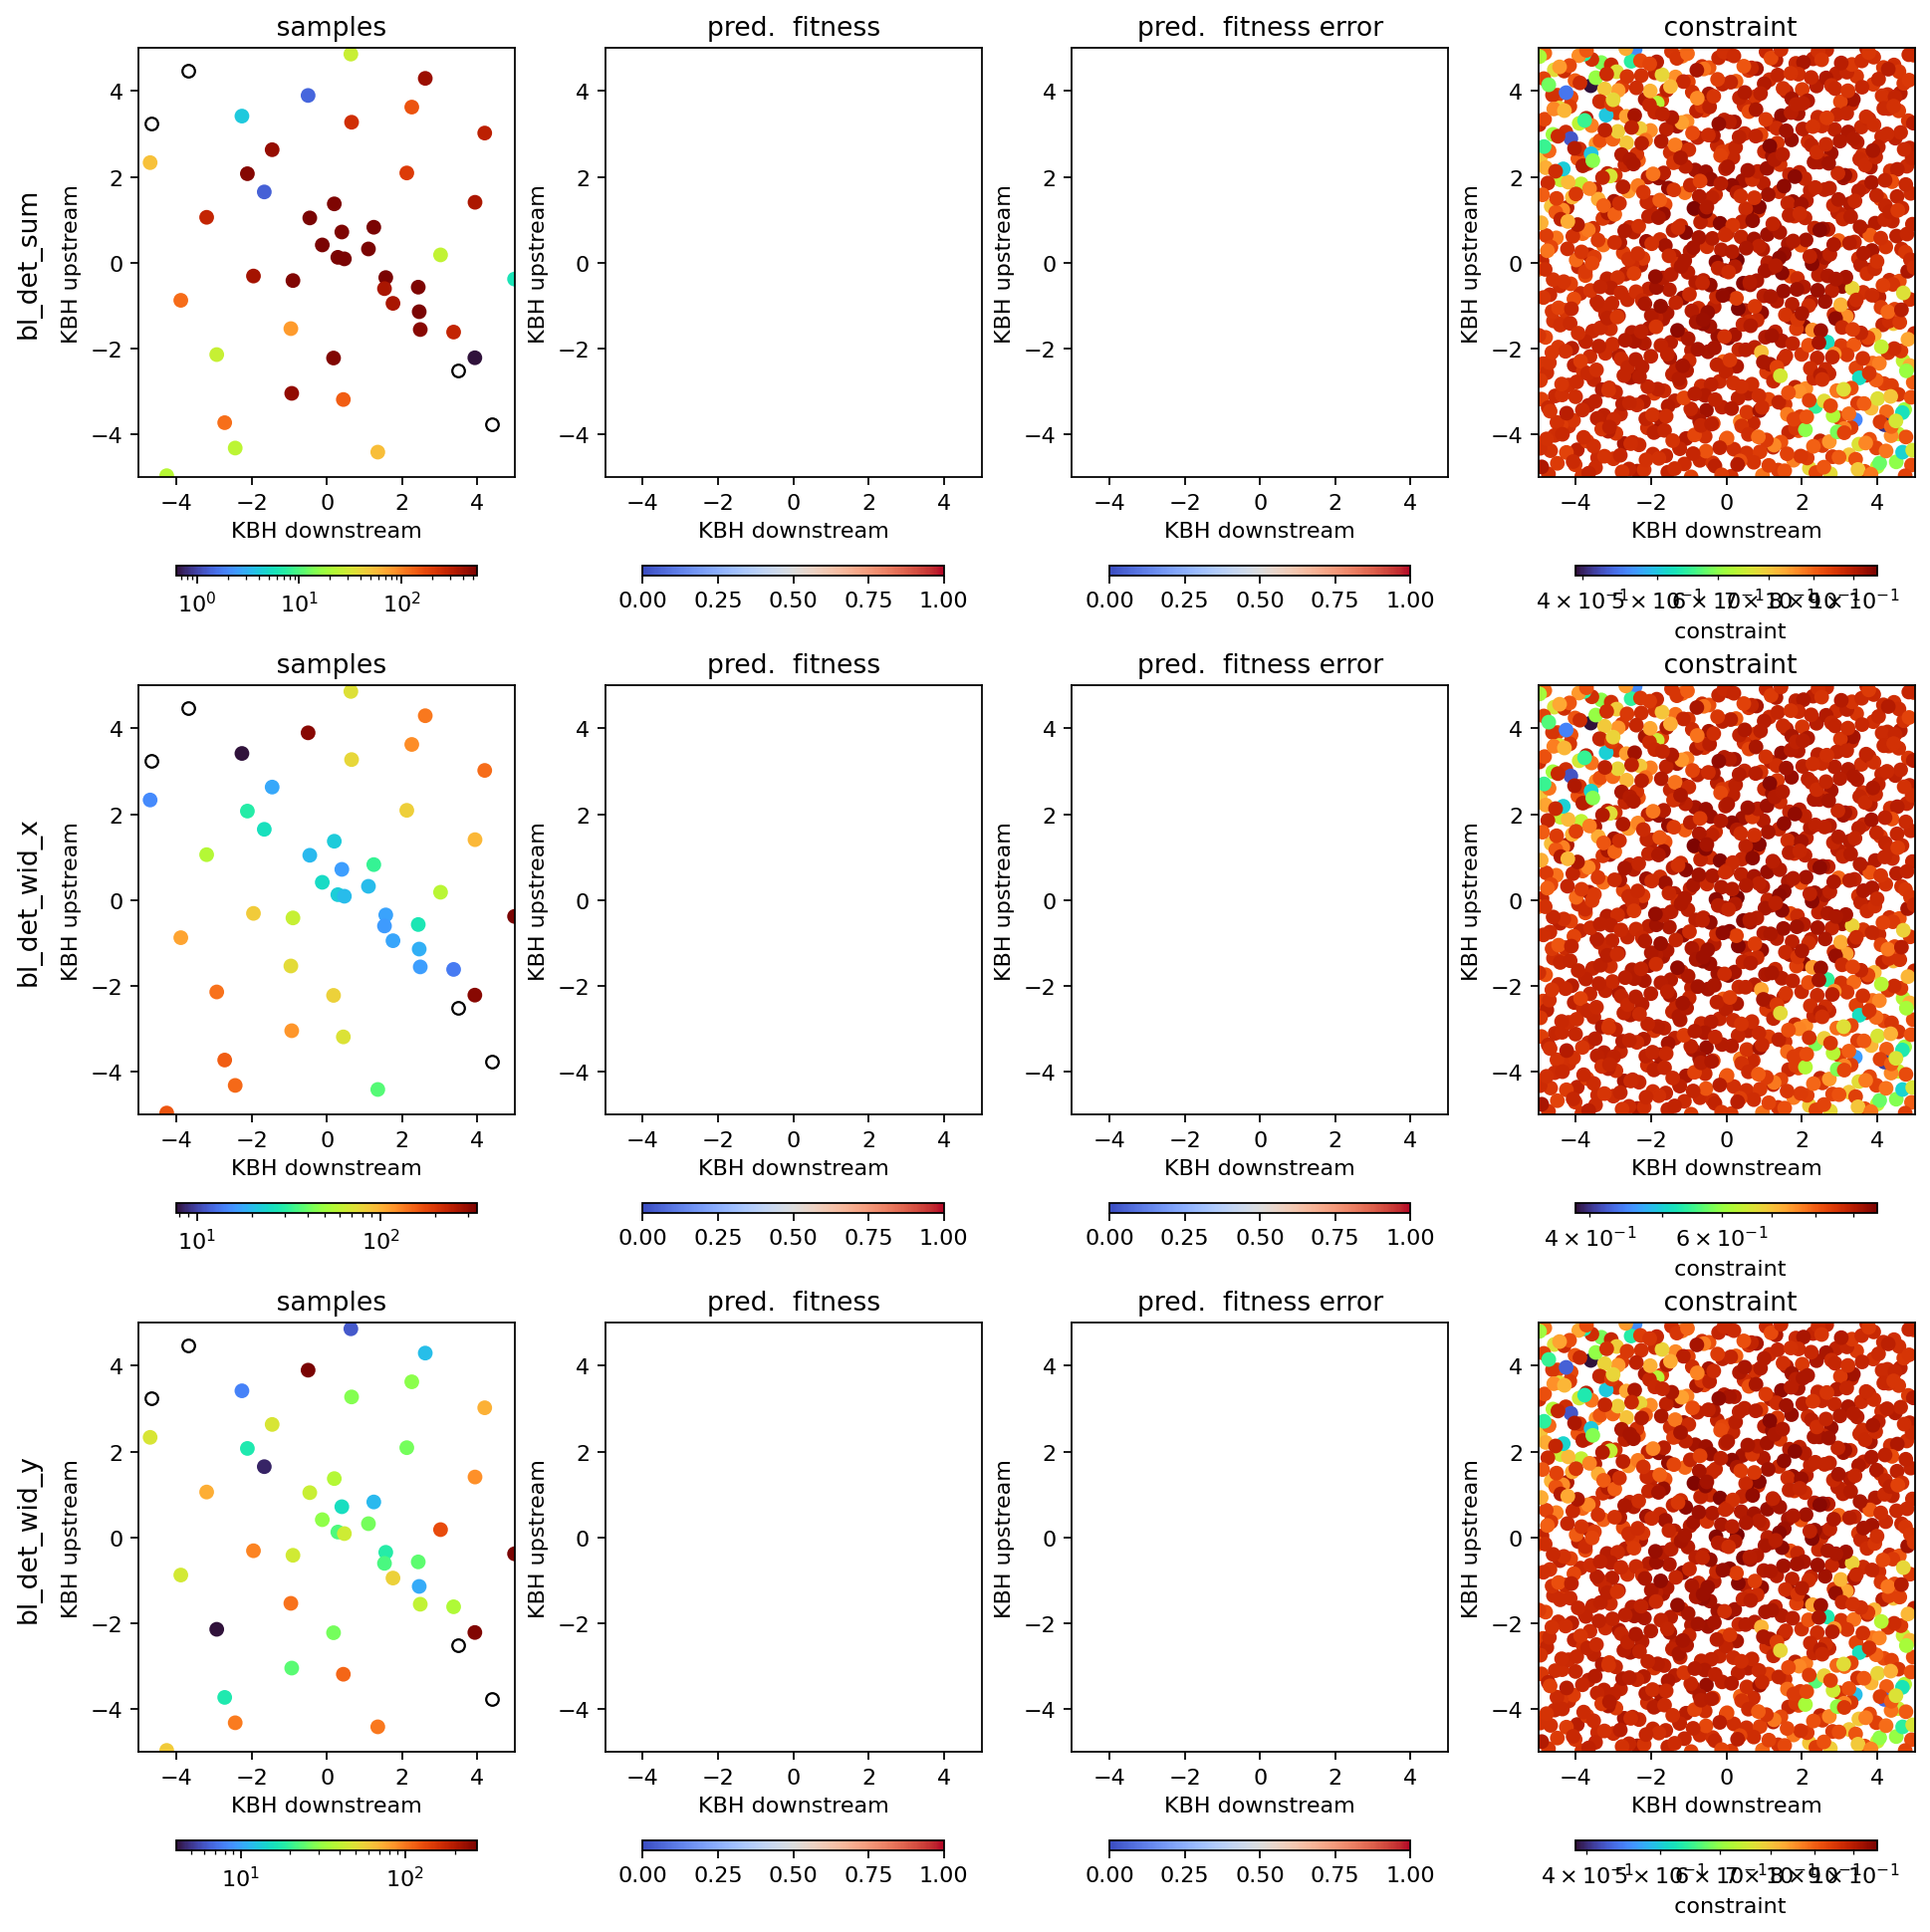

In [6]:
agent.plot_objectives(axes=(2, 3))